# ECE504 Project 1
Stephen Newberry

In [1]:
import sys
import logging
from timeit import default_timer as timer
from typing import NamedTuple
import numpy as np
import datetime

# First line, make sure Python is set up/runs
print("Stephen Newberry - Project 1 - ECE504 - Fall 2023")
print(f"Running Python {sys.version}")

logging.basicConfig(format='[%(levelname)s] %(message)s',
                    datefmt='%d/%m/%Y %I:%M:%S %p', level=logging.INFO)

Stephen Newberry - Project 1 - ECE504 - Fall 2023
Running Python 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Import Simbeor for Field Solver
sys.path.append("C:/Users/steph/Documents/Education/CLASS06_2023F_ECE504/projects/project1/code")
from simbeor_sdk import simbeor
if not simbeor.Initialize():
    logging.warning("Error initializing Simbeor")

if not simbeor.SetLicense(
        'C:\\Users\\steph\\Documents\\ShieldDigitalDesign\\Software\\Licenses', 'simbeor_verify'):
    logging.warning("Error setting Simbeor license")


## Substrate Design

The substrate will be a standard, uncoated microstrip. The metal will be 1.2mil thick (standard 1oz Cu after processing). Conductivity will use the ideal value of 5.8E+06 S/m for copper. 
The dielectric will be modeled after Isola FR408HR, which is a standard dielectric used for low- to medium-speed digital PCB applications.
https://www.isola-group.com/pcb-laminates-prepreg/fr408hr-laminate-and-prepreg/
We will use the dielectric values from an 8mil, 2x3313 weave, 55% resin content, core material. It has a Dk/Df of 3.68/0.0087 at 1 GHz.

Copper roughness will not be modeled, nor will trace etch-back (rectangular cross-section).

In [3]:
# Configure substrate
cu_thickness = 1.2 #mils
diel_thickness = 8.0 #mils
dk = 3.68
df = 0.0087
cu_cond = 5.80046403712e7 #S/m

# NOTE: Ignoring roughness

simbeor.ProjectDelete("TLINE")  # In case it exists, delete
model_name = "tline_model"
prj = simbeor.ProjectCreate("TLINE", True, True, 25.0)
if (prj == 0):
    logging.error("Project exists, delete project first")

# Configure frequency sweep
freq_sweep = simbeor.InitFrequencySweep()
freq_sweep['SweepType'] = 'Tabulated'
freq_sweep['Start'] = 1 # GHz
freq_sweep['Stop'] = 1 # GHz

# Add materials to project
# Air
air = simbeor.MaterialAddDielectric("TLINE\\Air", 1.0, 0.0, 1e9, 0, 1e4, 1e12)
if (air == 0):
    logging.error("Error creating air")
# Conductor
rel_res = (1/cu_cond)/1.724e-8
cond = simbeor.MaterialAddConductor("TLINE\\Copper", rel_res, 0, 0.004)
if (cond == 0):
    logging.error("Error creating conductor")
# Dielectric
diel = simbeor.MaterialAddDielectric(
    "TLINE\\Dielectric", dk, df, 1e9, 0, 1e4, 1e12)
if (diel == 0):
    logging.error("Error creating dielectric")

# Create Stackup (top to bottom)
layer1 = simbeor.LayerAddSignal("TLINE\\L1", "Copper", "Air", simbeor.mil_to_m(cu_thickness))
if (layer1 == 0):
    logging.error("Error creating stackup Layer 1")
diel1 = simbeor.LayerAddMedium("TLINE\\DIEL", "Dielectric", simbeor.mil_to_m(diel_thickness))
if (diel1 == 0):
    logging.error("Error creating stackup dielectric")
layer2 = simbeor.LayerAddCover("TLINE\\L2", "Copper", simbeor.mil_to_m(0.1))


In [4]:
# Set up a Named Tuple as output
class SimResult(NamedTuple):
    z0: float # Ohms
    e_length: float # Degrees
    exec_time: float # Seconds

# Define field-solver simulation
def simulate_tline(width, length) -> SimResult:
    """Takes input geometry of t-line and returns tuple containing Z0 (Ohms) and electrical length (deg). 
    Also returns execution time in seconds

    :param width: trace width of the input line in mils 
    :param length: length of the transmission line in mils
    """
    # T-Line
    tline = simbeor.InitSingleTLine()
    tline['Width'] = simbeor.mil_to_m(width)
    tline['StripShape'] = "Rectangular"
    tline['EtchFactor'] = 0  # No etch factor
    tline['Clearance'] = 0.0  # Set to zero for no coplanar ground
    tline['LayerName'] = "L1"
    tline['BottomRefLayer'] = "L2"

    simbeor.ModelDelete(model_name) # In case it exists
    # Also, would like to time this specific function and record it
    ##### MAIN SIMBEOR FUNCTION ######
    start_time = timer()
    results = simbeor.ModelSingleTLine_SFS(model_name, tline, freq_sweep, 0)
    end_time = timer()
    #logging.info(f"Simbeor function elapsed time: {end_time-start_time} seconds")
    ##################################
    
    exec_time = end_time - start_time
    
    z0 = simbeor.GetCharacteristicImpedances(model_name, 50, 1)[0]
    
    # 1 radian/meter is 0.001455 deg per mil

    e_length_rad_per_meter = simbeor.GetPropagationConstants(model_name, "PhaseConstant",1)[0]
    e_length = e_length_rad_per_meter * 0.001455 * length
    
    sim_result = SimResult(
        z0=z0,
        e_length=e_length,
        exec_time=exec_time
    )
    # logging.info(f"For inputs {width}, {length}\nResult: {sim_result}\n")
    return sim_result


In [5]:
# Example
simulate_tline(width=16, length=10000)

SimResult(z0=51.22717033249684, e_length=508.4024955171149, exec_time=0.0012652000004891306)

## Training Data
Training data will be a Pandas dataframe. Each row is an instance. It will have the following columns:

* Trace width, mils (input)
* Trace length, mils (input)
* Z0 at 1 GHz, ohms (output)
* Electrical length at 1 GHz, degrees (output)
* Execution time

A typical microwave trace will be anywhere from 4mil upwards of 25mil or so on a PCB, but since we're fixing our substrate at 8mil thickness, that means we'd want to center on ~16mil for a 50ohm line. For length, we'll use 6" as a mean with a Rayleigh distribution.

Actually.... this distribution kinda sucks. Uniform for now...
wait, lognormal!


In [6]:
import pandas as pd

# Next, we need to generate the training data
generate_new_training_data = False
num_training_points = 1000000
num_validation_points = int(np.floor(.2 * num_training_points))
num_test_points = int(np.floor(0.2 * num_training_points))

if generate_new_training_data:
    timestamp = datetime.datetime.now()
    timestamp_str = f"{timestamp.year}_{timestamp.month}_{timestamp.day}_{timestamp.time().hour}{timestamp.time().minute}{timestamp.time().second}"
    print(f"Generating data as of {timestamp}")
    
    if generate_new_training_data:
        # Create blank CSV
        fields = ['width', 'length', 'z0', 'e_length', 'exec_time']
    
        # Min/Max ranges
        trace_width_min = 0.1 # mil
        trace_width_max = 500.0
        trace_width_mean = 16.0
        trace_length_min = 1 # mil
        trace_length_max = 100000 # 100 inches
        trace_length_mean = 6000
        
        # Lognormal settings
        sigma = 0.75
    
        train = pd.DataFrame(columns=fields)
        for i in range(num_training_points):
            width = np.random.lognormal(sigma=sigma, mean=np.log(trace_width_mean))
            length = np.random.lognormal(sigma=sigma, mean=np.log(trace_length_mean))
            
            sim_result = simulate_tline(width,length)
            
            # Assign the result values
            z0 = sim_result.z0
            e_length = sim_result.e_length
            exec_time = sim_result.exec_time
            
            new_row = pd.DataFrame([[width, length, z0, e_length, exec_time]], columns=fields)
            
            train = pd.concat([train, new_row], ignore_index=True)
        train.to_csv(f'./training_data/{timestamp_str}_train.csv')
    
        # Probably should have this be some kind of function. Later :)
        val = pd.DataFrame(columns=fields)
        for i in range(num_validation_points):
            width = np.random.lognormal(sigma=sigma, mean=np.log(trace_width_mean))
            length = np.random.lognormal(sigma=sigma, mean=np.log(trace_length_mean))
        
            sim_result = simulate_tline(width,length)
        
            # Assign the result values
            z0 = sim_result.z0
            e_length = sim_result.e_length
            exec_time = sim_result.exec_time

            new_row = pd.DataFrame([[width, length, z0, e_length, exec_time]], columns=fields)

            val = pd.concat([val, new_row], ignore_index=True)
        val.to_csv(f'./training_data/{timestamp_str}_val.csv')

        test = pd.DataFrame(columns=fields)
        for i in range(num_test_points):
            width = np.random.lognormal(sigma=sigma, mean=np.log(trace_width_mean))
            length = np.random.lognormal(sigma=sigma, mean=np.log(trace_length_mean))
        
            sim_result = simulate_tline(width,length)
        
            # Assign the result values
            z0 = sim_result.z0
            e_length = sim_result.e_length
            exec_time = sim_result.exec_time

            new_row = pd.DataFrame([[width, length, z0, e_length, exec_time]], columns=fields)

            test = pd.concat([test, new_row], ignore_index=True)
        test.to_csv(f'./training_data/{timestamp_str}_test.csv')
    
    
# Took 2.25hrs to train 1M points

[INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[INFO] NumExpr defaulting to 8 threads.


In [7]:
from keras.models import Sequential
from keras.layers import Dense

timestamp_str = "2023_10_2_212631"

if timestamp_str is None:
    timestamp_str = "2023_10_2_212631"
    
# Re-read to dataframes
training_data_df = pd.read_csv(f'./training_data/{timestamp_str}_train.csv')
val_data_df = pd.read_csv(f'./training_data/{timestamp_str}_val.csv')
test_data_df = pd.read_csv(f'./training_data/{timestamp_str}_test.csv')

# Friendly data format
training_input = []
for i in range(len(training_data_df.index)):
    training_input.append([training_data_df['width'].iloc[i], training_data_df['length'].iloc[i]])

training_output = []
training_output_z0 = []
training_output_el = []
for i in range(len(training_data_df.index)):
    training_output.append([training_data_df['z0'].iloc[i], training_data_df['e_length'].iloc[i]])
    training_output_z0.append([training_data_df['z0'].iloc[i]])
    training_output_el.append([training_data_df['e_length'].iloc[i]])

val_input = []
for i in range(len(val_data_df.index)):
    val_input.append([val_data_df['width'].iloc[i], val_data_df['length'].iloc[i]])

val_output = []
val_output_z0 = []
val_output_el = []
for i in range(len(val_data_df.index)):
    val_output.append([val_data_df['z0'].iloc[i], val_data_df['e_length'].iloc[i]])
    val_output_z0.append([val_data_df['z0'].iloc[i]])
    val_output_el.append([val_data_df['e_length'].iloc[i]])   

test_input = []
for i in range(len(test_data_df.index)):
    test_input.append([test_data_df['width'].iloc[i], test_data_df['length'].iloc[i]])

test_output = []
test_output_z0 = []
test_output_el = []
for i in range(len(test_data_df.index)):
    test_output.append([test_data_df['z0'].iloc[i], test_data_df['e_length'].iloc[i]])
    test_output_z0.append([test_data_df['z0'].iloc[i]])
    test_output_el.append([test_data_df['e_length'].iloc[i]])

Execution Time Average: 0.9819635386760346 ms per point
Fastest Execution: 0.8709999965503 ms
Slowest Execution: 4.7723000170663 ms
Median Execution: 0.9781999979168001 ms

Min/Median/Max Width: 0.357/15.977/499.219

Min/Median/Max Length: 135.848/5998.074/190691.811


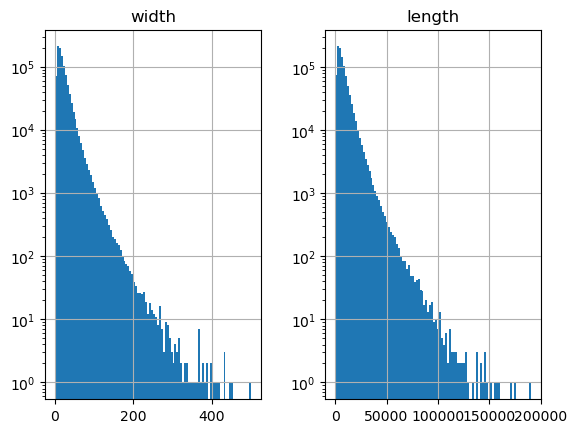

In [8]:
# Plot training data distribution
hist=training_data_df.hist(bins=100, column=['width', 'length'], log=True)
print(f"Execution Time Average: {sum(training_data_df['exec_time'])*1000/1000000} ms per point")
print(f"Fastest Execution: {min(training_data_df['exec_time']*1000)} ms")
print(f"Slowest Execution: {max(training_data_df['exec_time']*1000)} ms")
print(f"Median Execution: {np.median(training_data_df['exec_time']*1000)} ms")
print("\n")
print(f"Min/Median/Max Width: {min(training_data_df['width']):.3f}/{np.median(training_data_df['width']):.3f}/{max(training_data_df['width']):.3f}\n")
print(f"Min/Median/Max Length: {min(training_data_df['length']):.3f}/{np.median(training_data_df['length']):.3f}/{max(training_data_df['length']):.3f}")



## Tuning of Model

Using Keras Tuner:
https://www.tensorflow.org/tutorials/keras/keras_tuner

Search the following options:
* Number of layers (between 2 and 5)
* Nodes: 32 to 512 in steps of 32
* Activation between relu, elu, tanh, linear, softplus
* Optimizer between adam, sgd, adagrad, adadelta, nadam
* loss between MSE, MAE, mean sq. log., huber
* learning rate between 0.1, 0.01, 0.001? Leaving default for now

Note that we will keep the "metric" as MSE for all cases, so we can easily compare

In [304]:
import keras_tuner as kt

activation_list = ['linear', 'relu', 'tanh', 'elu', 'softplus']
optimizer_list = ['adam', 'sgd', 'adagrad', 'adadelta', 'nadam']
loss_list = ['mean_squared_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'huber']
lr_list = [0.1, 0.01, 0.001]


def build_tuning_model(hp):
    
    model = keras.Sequential()
    
    # Number of Layers
    for i in range(hp.Int('num_layers', min_value = 2, max_value=5)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                     activation=hp.Choice('activation_'+str(i), values = activation_list)))
        
    # Output
    model.add(keras.layers.Dense(units=1, activation='linear'))
    
    # Compile
    # model.compile(optimizer=hp.Choice('optimizer', values=optimizer_list), loss=hp.Choice('loss', values=loss_list), metrics=['mse'])
    model.compile(optimizer=hp.Choice('optimizer', values=optimizer_list), loss='mse', metrics='mse')


    return model

In [305]:
tuner = kt.tuners.Hyperband(build_tuning_model, objective='val_loss', max_epochs=10, factor=3, project_name='tune_z0_only')

In [16]:
train_new_model = False


In [302]:
x_train = np.array(training_input)
y_train = np.array(training_output_z0)
x_test = np.array(val_input)
y_test = np.array(val_output_z0)

In [306]:
import keras
if train_new_model:
    tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))  
    
    best_hyperparams = tuner.get_best_hyperparameters()[0]
    
    final_model = tuner.hypermodel.build(best_hyperparams)
    
    print(best_hyperparams)
    
    

Trial 20 Complete [00h 10m 52s]
val_loss: 7.8533101081848145

Best val_loss So Far: 2.092315196990967
Total elapsed time: 02h 00m 04s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
5                 |4                 |num_layers
288               |416               |units_0
tanh              |relu              |activation_0
96                |320               |units_1
softplus          |tanh              |activation_1
adagrad           |adadelta          |optimizer
320               |352               |units_2
relu              |tanh              |activation_2
224               |416               |units_3
softplus          |relu              |activation_3
448               |224               |units_4
tanh              |tanh              |activation_4
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tune

KeyboardInterrupt: 

In [307]:
best_hyperparams = tuner.get_best_hyperparameters()[0]

final_model = tuner.hypermodel.build(best_hyperparams)

print(best_hyperparams)

In [308]:
tuner.results_summary()

Results summary
Results in .\tune_z0_only
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0018 summary
Hyperparameters:
num_layers: 4
units_0: 416
activation_0: relu
units_1: 320
activation_1: tanh
optimizer: adadelta
units_2: 352
activation_2: tanh
units_3: 416
activation_3: relu
units_4: 224
activation_4: tanh
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0012
Score: 2.092315196990967

Trial 0004 summary
Hyperparameters:
num_layers: 4
units_0: 192
activation_0: elu
units_1: 448
activation_1: tanh
optimizer: adadelta
units_2: 192
activation_2: linear
units_3: 96
activation_3: softplus
units_4: 192
activation_4: linear
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 3.5169081687927246

Trial 0012 summary
Hyperparameters:
num_layers: 4
units_0: 416
activation_0: relu
units_1: 320
activation_1: tanh
optimizer: adadelta
units_2: 352
activation_2: tanh
units_3: 416
activation_3: relu
units_4: 

In [309]:
model=tuner.hypermodel.build(best_hyperparams)

Took best hyperparam model but modified a bit further

In [289]:
def build_final_model():

    model = keras.Sequential()

    model.add(keras.layers.BatchNormalization(axis=-1, input_shape=(2,)))

    # Number of Layers
    model.add(keras.layers.Dense(units=16, input_shape=(2,), activation='tanh'))
    # model.add(keras.layers.Dense(units=64, activation='relu'))
    model.add(keras.layers.Dense(units=32, activation='relu'))
    # model.add(keras.layers.Dense(units=224, activation='relu'))
    model.add(keras.layers.Dense(units=16, activation='relu'))


    # Output
    model.add(keras.layers.Dense(units=1, activation='linear'))

    # Compile
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics='mse')

    return model

In [290]:
model = None

In [291]:
model = build_final_model()
model.summary(expand_nested=True, show_trainable=True)

Model: "sequential_53"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 batch_normalization_31 (Ba  (None, 2)                 8         Y          
 tchNormalization)                                                          
                                                                            
 dense_240 (Dense)           (None, 16)                48        Y          
                                                                            
 dense_241 (Dense)           (None, 32)                544       Y          
                                                                            
 dense_242 (Dense)           (None, 16)                528       Y          
                                                                            
 dense_243 (Dense)           (None, 1)                 17        Y          
                                                     

In [311]:
history = model.fit(x_train, y_train, epochs=100, batch_size=10000, validation_data=(x_test, y_test))
# history = model.fit(x_train, y_train[:,1], epochs=100, batch_size=10000)


Epoch 1/100
100/100 [==============================] - 15s 141ms/step - loss: 3234.2000 - mse: 3234.2000 - val_loss: 3144.1606 - val_mse: 3144.1606
Epoch 2/100
100/100 [==============================] - 14s 140ms/step - loss: 3059.8755 - mse: 3059.8760 - val_loss: 2947.5266 - val_mse: 2947.5264
Epoch 3/100
100/100 [==============================] - 14s 140ms/step - loss: 2794.7954 - mse: 2794.7954 - val_loss: 2573.7407 - val_mse: 2573.7407
Epoch 4/100
100/100 [==============================] - 14s 141ms/step - loss: 2208.2837 - mse: 2208.2837 - val_loss: 1730.3064 - val_mse: 1730.3064
Epoch 5/100
100/100 [==============================] - 14s 141ms/step - loss: 1199.0020 - mse: 1199.0020 - val_loss: 734.4716 - val_mse: 734.4716
Epoch 6/100
100/100 [==============================] - 14s 141ms/step - loss: 550.1268 - mse: 550.1268 - val_loss: 454.0094 - val_mse: 454.0094
Epoch 7/100
100/100 [==============================] - 14s 141ms/step - loss: 435.8362 - mse: 435.8362 - val_loss: 422

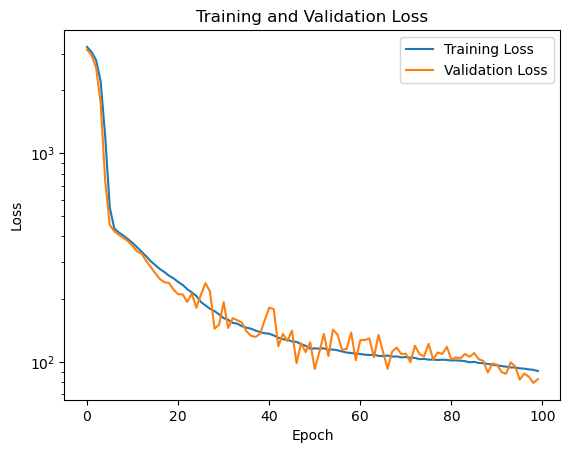

In [312]:
# Plot loss
import matplotlib.pyplot as plt
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [124]:
loss = model.evaluate(x_test, y_test)

x_unseen = np.array(test_input)
y_unseen = np.array(test_output)
loss_new = model.evaluate(x_unseen, y_unseen)

6250/6250 [==============================] - 9s 1ms/step - loss: 0.5455 - mean_squared_logarithmic_error: 0.5455


In [ ]:
model.save(f'./models_k/model_{timestamp_str}.keras')

In [313]:
# Example of predictions
samples = np.array([[16,1000],[45.5,321]])
preds = model.predict(samples)

print(f"Predictions are: ",preds)

print(simulate_tline(16,1000))
print(simulate_tline(45.5,321))

# PREDICTIONS - somewhere in here, don't forget to check execution time of predictions

1/1 [==============================] - 0s 67ms/step
Predictions are:  [[45.52143 ]
 [26.398302]]
SimResult(z0=51.22717033249684, e_length=50.840249551711494, exec_time=0.0010742999729700387)
SimResult(z0=25.257306588425404, e_length=17.190317714778836, exec_time=0.0008866999996826053)


In [266]:
print(model.predict([[160,1000]]))
print(simulate_tline(160,1000))

1/1 [==============================] - 0s 75ms/step
[[64.29753]]
SimResult(z0=8.725620611491474, e_length=56.49072449745346, exec_time=0.0011832000454887748)


In [ ]:
# Simbeor Cleanup
simbeor.ReleaseLicense()
simbeor.Cleanup()
simbeor.Uninitialize()

In [ ]:
# Create 2nd machine learning model (reverse)

In [ ]:
# Create application which queries the user!